##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 그래디언트 및 자동 미분 소개

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/autodiff" class=""><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/autodiff.ipynb" class=""><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 자동 미분 및 그래디언트

[자동 미분](https://en.wikipedia.org/wiki/Automatic_differentiation)은 신경망 학습을 위한 [역전파](https://en.wikipedia.org/wiki/Backpropagation)와 같은 머신러닝 알고리즘을 구현하는 데 유용합니다.

이 가이드에서는 특히 [즉시 실행](eager.ipynb)에서 TensorFlow로 그래디언트를 계산하는 방법을 알아봅니다.

## 설정

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## 그래디언트 계산하기

자동으로 미분하기 위해 TensorFlow는 *정방향 패스* 동안 어떤 연산이 어떤 순서로 발생하는지 기억해야 합니다. 그런 다음 *역방향 패스* 동안 TensorFlow는 이 연산 목록을 역순으로 이동하여 그래디언트를 계산합니다.

## 그래디언트 테이프

텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) API를 제공합니다. `tf.GradientTape`는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 그 다음 텐서플로는 [후진 방식 자동 미분(reverse mode differentiation)](https://en.wikipedia.org/wiki/Automatic_differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

예를 들면:

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

2021-08-14 00:35:06.963604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2021-08-14 00:35:06.971688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 00:35:06.972576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 00:35:06.974692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-14 00:35:06.975239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

일부 연산을 기록한 후에는 `GradientTape.gradient(target, sources)`를 사용하여 일부 소스(종종 모델 변수)에 상대적인 일부 대상(종종 손실)의 그래디언트를 계산합니다.

In [4]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

위의 예제는 스칼라를 사용하지만, `tf.GradientTape`는 모든 텐서에서 쉽게 작동합니다.

In [5]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

두 변수 모두에 대해 `loss`의 그래디언트를 가져오려면, 두 변수를 `gradient` 메서드에 소스로 전달할 수 있습니다. 테이프는 소스가 전달되는 방식에 대해 융통성이 있으며 목록 또는 사전의 중첩된 조합을 허용하고 같은 방식으로 구조화된 그래디언트를 반환합니다(`tf.nest` 참조).

In [6]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

각 소스에 대한 그래디언트는 소스의 형상을 갖습니다.

In [7]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


다음은 그래디언트 계산입니다. 이번에는 변수의 사전을 전달합니다.

In [8]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.42549   , 0.29411206], dtype=float32)>

## 모델에 대한 그래디언트

[검사점 설정](checkpoint.ipynb) 및 [내보내기](saved_model.ipynb)를 위해 `tf.Variables`를 `tf.Module` 또는 해당 서브 클래스(<code>layers.Layer</code>와 <code>keras.Model</code>) 중 하나로 수집하는 것이 일반적입니다.

대부분의 경우 모델의 훈련 가능한 변수에 대한 그래디언트를 계산하려고 합니다. `tf.Module`의 모든 서브 클래스는 `Module.trainable_variables` 속성에서 변수를 집계하므로 몇 줄의 코드로 이러한 그래디언트를 계산할 수 있습니다. 

In [9]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [10]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## 테이프의 감시 대상 제어하기

기본 동작은 훈련 가능한 `tf.Variable`에 액세스한 후 모든 연산을 기록하는 것입니다. 그 이유는 다음과 같습니다.

- 테이프는 역방향 패스의 그래디언트를 계산하기 위해 정방향 패스에 기록할 연산을 알아야 합니다.
- 테이프는 중간 출력에 대한 참조를 보유하므로 불필요한 연산을 기록하지 않습니다.
- 가장 일반적인 사용 사례는 모든 모델의 훈련 가능한 변수에 대해 손실의 그래디언트를 계산하는 것입니다.

예를 들어, 다음은 `tf.Tensor`가 기본적으로 "감시"되지 않고 `tf.Variable`을 훈련할 수 없기 때문에 그래디언트를 계산하지 못합니다.

In [11]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


`GradientTape.watched_variables` 메서드를 사용하여 테이프에서 감시 중인 변수를 나열할 수 있습니다.

In [12]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape`는 사용자가 감시 대상 또는 감시 예외 대상을 제어할 수 있는 후크를 제공합니다.

`tf.Tensor`에 대한 그래디언트를 기록하려면 `GradientTape.watch(x)`를 호출해야 합니다.

In [13]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


반대로, 모든 `tf.Variables`을 감시하는 기본 동작을 비활성화하려면, 그래디언트 테이프를 만들 때 `watch_accessed_variables=False`를 설정합니다. 이 계산은 두 가지 변수를 사용하지만, 변수 중 하나의 그래디언트만 연결합니다.

In [14]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

`x0`에서 `GradientTape.watch`가 호출되지 않았으므로 이에 대한 그래디언트가 계산되지 않습니다.

In [15]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## 중간 결과

`tf.GradientTape` 컨텍스트 내에서 계산된 중간값과 관련하여 출력의 그래디언트를 요청할 수도 있습니다.

In [16]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


기본적으로, `GradientTape.gradient` 메서드가 호출되면 `GradientTape`가 보유한 리소스가 해제됩니다. 동일한 계산에 대해 여러 그래디언트를 계산하려면 `persistent=True` 그래디언트 테이프를 만듭니다. 이렇게 하면 테이프 객체가 가비지 수집될 때 리소스가 해제되면 `gradient` 메서드를 여러 번 호출할 수 있습니다. 예를 들면 다음과 같습니다.

In [17]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # 108.0 (4 * x**3 at x = 3)
print(tape.gradient(y, x).numpy())  # 6.0 (2 * x)

[  4. 108.]
[2. 6.]


In [18]:
del tape   # Drop the reference to the tape

## 성능에 대한 참고 사항

- 그래디언트 테이프 컨텍스트 내에서 연산을 수행하는 것과 관련하여 작은 오버헤드가 있습니다. 대부분의 Eager 실행에는 상당한 비용이 들지 않지만, 필요한 경우에만 테이프 컨텍스트를 사용해야 합니다.

- 그래디언트 테이프는 메모리를 사용하여 역방향 패스 동안 사용하기 위해 입력 및 출력을 포함한 중간 결과를 저장합니다.

    효율성을 위해 (`ReLU`와 같은) 일부 연산은 중간 결과를 유지할 필요가 없으며 정방향 패스 동안에 정리됩니다. 그러나 테이프에서 `persistent=True`를 사용하면 *아무것도 삭제되지 않으며* 최대 메모리 사용량이 높아집니다.

## 스칼라가 아닌 대상의 그래디언트

그래디언트는 기본적으로 스칼라에 대한 연산입니다.

In [19]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


따라서, 여러 대상의 그래디언트를 요청하면 각 소스의 결과는 다음과 같습니다.

- 대상의 합계 또는 그에 상응하는 그래디언트
- 각 대상의 그래디언트의 합계

In [20]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


마찬가지로, 대상이 스칼라가 아닌 경우 합계의 그래디언트가 계산됩니다.

In [21]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


이렇게 하면, 손실 컬렉션 합계의 그래디언트 또는 요소별 손실 계산 합계의 그래디언트를 간단하게 구할 수 있습니다.

각 항목에 대해 별도의 그래디언트가 필요한 경우, [야고비안](advanced_autodiff.ipynb#jacobians)을 참조하세요.

어떤 경우에는 야고비안을 건너뛸 수 있습니다. 요소별 계산의 경우, 각 요소가 독립적이므로 합의 그래디언트는 입력 요소와 관련하여 각 요소의 미분을 제공합니다.

In [22]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

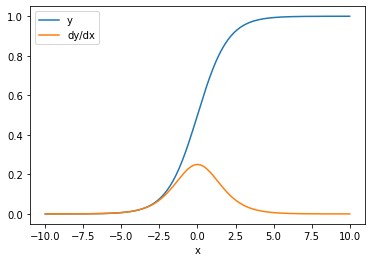

In [23]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## 흐름 제어하기

그래디언트 테이프는 실행되는 연산을 기록하기 때문에 Python 제어 흐름이 자연스럽게 처리됩니다(예: `if` 및 `while` 구문).

여기서는 `if`의 각 분기에 서로 다른 변수가 사용됩니다. 그래디언트는 사용된 변수에만 연결됩니다.

In [24]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


제어문 자체는 미분할 수 없으므로 그래디언트 기반 최적화 프로그램에는 보이지 않습니다.

위 예제에서 `x` 값에 따라 테이프는 `result = v0` 또는 `result = v1**2`를 기록합니다. `x`에 대한 그래디언트는 항상 `None`입니다.

In [25]:
dx = tape.gradient(result, x)

print(dx)

None


## `None`의 그래디언트 구하기

대상이 소스에 연결되어 있지 않으면 그래디언트는 `None`입니다.


In [26]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


여기서 `z`는 명확하게 `x`에 연결되어 있지 않지만, 그래디언트의 연결을 끊을 수 있는 몇 가지 덜 명확한 방법이 있습니다.

### 1. 변수를 텐서로 대체했습니다.

[ "테이프의 감시 대상 제어"{/ a0} 섹션에서 테이프가 자동으로 `tf.Variable`을 감시하지만 `tf.Tensor`는 감시하지 않는 것을 살펴보았습니다.]()

한 가지 일반적인 오류는 `Variable.assign`를 사용하여 `tf.Variable`를 업데이트하는 대신 실수로 `tf.Variable`을 `tf.Tensor`로 대체하는 것입니다. 예를 들면, 다음과 같습니다.

In [27]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. TensorFlow 외부에서 계산했습니다.

계산에서 TensorFlow를 종료하면 테이프가 그래디언트 경로를 기록할 수 없습니다. 예를 들면, 다음과 같습니다.

In [28]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3. 정수 또는 문자열을 통해 그래디언트를 구했습니다.

정수와 문자열은 구별할 수 없습니다. 계산 경로에서 이러한 데이터 유형을 사용하면 그래디언트는 없습니다.

아무도 문자열을 미분할 것으로 기대하지는 않지만, `dtype`을 지정하지 않으면 실수로 `int` 상수 또는 변수를 만들기 쉽습니다.

In [29]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow는 유형 간에 자동으로 전송되지 않으므로 실제로 그래디언트가 누락되는 대신 유형 오류가 발생합니다.

### 5. 상태 저장 개체를 통해 그래디언트를 구했습니다.

상태가 그래디언트를 중지합니다. 상태 저장 객체에서 읽을 때 테이프는 현재 상태만 볼 수 있으며 현재 상태에 이르게 된 기록은 볼 수 없습니다.

`tf.Tensor`는 변경할 수 없습니다. 텐서가 작성된 후에는 변경할 수 없습니다. *값*은 있지만 *상태는* 없습니다. 지금까지 논의된 모든 연산은 상태 비저장입니다. `tf.matmul`의 출력은 입력에만 의존합니다.

`tf.Variable`은 내부 상태와 값을 갖습니다. 변수를 사용하면 상태를 읽습니다. 변수와 관련하여 그래디언트를 계산하는 것이 일반적이지만, 변수의 상태는 그래디언트 계산이 더 멀리 돌아가지 않도록 차단합니다. 예를 들면, 다음과 같습니다.


In [30]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


마찬가지로, `tf.data.Dataset` 반복기(iterator)와 `tf.queue`는 상태 저장이며 이들을 통과하는 텐서의 모든 그래디언트를 중지합니다.

## 그래디언트가 등록되지 않음

일부 `tf.Operation`는 **미분 불가능한 것으로 등록되어** `None`을 반환합니다. 다른 연산에는 **그래디언트가 등록되지 않았습니다**.

`tf.raw_ops` 페이지에는 그래디언트가 등록된 저수준 op가 표시됩니다.

그래디언트가 등록되지 않은 float op를 통해 그래디언트를 얻고자 시도하면 테이프가 자동으로 `None`을 반환하는 대신 오류가 발생합니다. 이렇게 하면 무언가 잘못되었다는 것을 알 수 있습니다.

예를 들어, `tf.image.adjust_contrast` 함수는 그래디언트를 가질 수 있지만 그래디언트는 구현되지 않은 `raw_ops.AdjustContrastv2`를 래핑합니다.


In [31]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


LookupError: gradient registry has no entry for: AdjustContrastv2


이 op를 통해 미분해야 하는 경우, 그래디언트를 구현하고 등록하거나(`tf.RegisterGradient` 사용) 다른 ops를 사용하여 함수를 다시 구현해야 합니다.

## None 대신 0

연결되지 않은 그래디언트의 경우 `None` 대신 0을 가져오는 것이 편리한 경우가 있습니다. 연결되지 않은 그래디언트가 있을 때 `unconnected_gradients` 인수를 사용하여 반환할 항목을 결정할 수 있습니다.

In [32]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
